# Examine ventilation tracers: CFCs, 14C, Cant

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
import os
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import cmocean

import xpersist as xp
cache_dir = '/glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields'
if (os.path.isdir(cache_dir)):
    xp.settings['cache_dir'] = cache_dir
os.makedirs(cache_dir, exist_ok=True)

os.environ['CESMDATAROOT'] = '/glade/scratch/mclong/inputdata'
import pop_tools


import climo_utils as cu
import utils
import glodap 

xr.set_options(arithmetic_join='exact');

## Set region mask for zonal means

/glade/work/mclong/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)


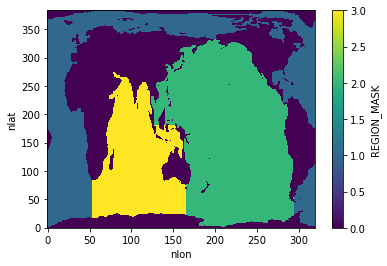

In [7]:
mask3d = utils.get_pop_region_mask_za(mask_type='3D')
basins = mask3d.region.rename({'region': 'basins'})
mask2d = utils.get_pop_region_mask_za(mask_type='2D')
mask2d.plot()

## Load zonal means of GLODAP observations

In [8]:
µmolkg_to_mmolm3 = 1026. * 1e-3 # µmol/kg --> mmol/m^3
µmolkg_to_mmolm3

1.026

In [9]:
fields_from = {
    'GLODAPv1': ['pCFC11', 'pCFC12', 'Del14C', 'Cant_v1'],
    'GLODAPv2.2016b_MappedClimatologies': ['Cant', 'ALK'],
    'GLODAPv1+Gruber2019': ['Cant_v1pGruber2019'],
}

ds_list = []
for product_name, fields_list in fields_from.items():
    ds = glodap.open_glodap_pop_grid(product_name)[fields_list]
    ds_list_i = []
    for v in fields_list:
        ds_list_i.append(
            utils.zonal_mean_via_fortran(
                ds, var=v, 
                grid='POP_gx1v7', 
                region_mask=mask2d,
                replace_kmt=True,
            )
        )
        
    ds_list.append(xr.merge(ds_list_i))

ds_za = xr.merge(ds_list)

with xr.set_options(keep_attrs=True):
    for v in ['Cant', 'Cant_v1', 'ALK']:
        if v in ds_za:
            ds_za[v] = ds_za[v] * µmolkg_to_mmolm3
            ds_za[v].attrs['units'] = 'mmol m$^{-3}$'

ds_za = ds_za.rename({k: f'{k}_obs' for k in ds_za.data_vars})
ds_za['basins'] = basins
ds_za

exists: /glade/work/mclong/adhoc-regridding/POP_gx1v7.nc
exists: /glade/work/mclong/adhoc-regridding/latlon_glodapv1.nc
source grid dims: (180, 360)
destination grid dims: (384, 320)
za ran successfully, writing netcdf output
za ran successfully, writing netcdf output
za ran successfully, writing netcdf output
za ran successfully, writing netcdf output
exists: /glade/work/mclong/adhoc-regridding/POP_gx1v7.nc
exists: /glade/work/mclong/adhoc-regridding/latlon_glodapv2.nc
source grid dims: (180, 360)
destination grid dims: (384, 320)
za ran successfully, writing netcdf output
za ran successfully, writing netcdf output
exists: /glade/work/mclong/adhoc-regridding/POP_gx1v7.nc
exists: /glade/work/mclong/adhoc-regridding/latlon_glodapv1.nc
source grid dims: (180, 360)
destination grid dims: (384, 320)
za ran successfully, writing netcdf output


<xarray.Dataset>
Dimensions:                 (basins: 4, lat_t: 394, lat_t_edges: 395, z_t: 60)
Coordinates:
  * basins                  (basins) <U14 'Global' ... 'Indian Ocean'
  * lat_t                   (lat_t) float32 -79.22 -78.69 -78.15 ... 89.37 89.9
  * lat_t_edges             (lat_t_edges) float32 -79.49 -78.95 ... 89.64 90.0
  * z_t                     (z_t) float64 500.0 1.5e+03 ... 5.125e+05 5.375e+05
Data variables:
    pCFC11_obs              (basins, z_t, lat_t) float64 ...
    pCFC12_obs              (basins, z_t, lat_t) float64 ...
    Del14C_obs              (basins, z_t, lat_t) float64 ...
    Cant_v1_obs             (basins, z_t, lat_t) float64 nan nan ... nan nan
    Cant_obs                (basins, z_t, lat_t) float64 nan nan ... nan nan
    ALK_obs                 (basins, z_t, lat_t) float64 nan nan ... nan nan
    Cant_v1pGruber2019_obs  (basins, z_t, lat_t) float64 ...

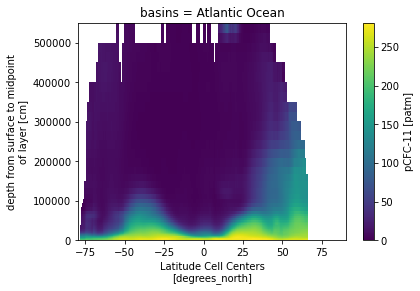

In [10]:
ds_za.pCFC11_obs.isel(basins=1).plot()

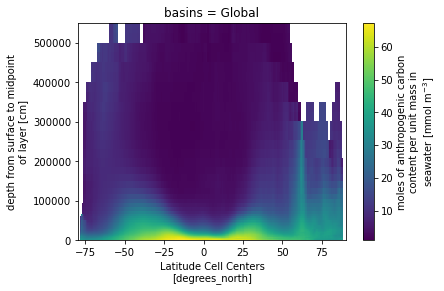

In [11]:
ds_za.Cant_obs.isel(basins=0).plot()

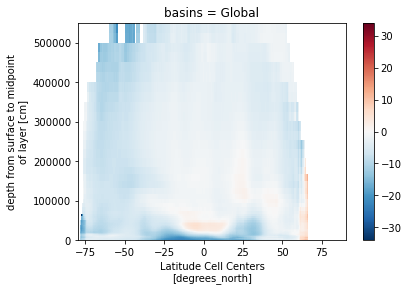

In [12]:
(ds_za.Cant_v1_obs - ds_za.Cant_obs).isel(basins=0).plot()

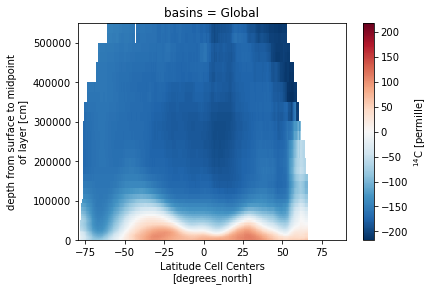

In [13]:
ds_za.Del14C_obs.isel(basins=0).plot()

## Load data from CESM integrations

In [14]:
cluster, client = utils.get_ClusterClient()
cluster.scale(12) #adapt(minimum_jobs=0, maximum_jobs=24)
client

/glade/work/mclong/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://10.12.206.51:38853 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/proxy/45756/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [15]:
time_slice_glodapv2 = slice('2002-01-15', '2003-01-15')
time_slice_glodapv1 = slice('1990-01-15', '2001-01-15')
time_slice_Cant_v1pGruber2019 = slice('2007-01-15', '2008-01-15')

cesm_fields = dict(
    Cant=time_slice_glodapv2,
    Cant_v1=time_slice_glodapv1,
    Cant_v1pGruber2019=time_slice_Cant_v1pGruber2019,
    ALK=time_slice_glodapv2,    
    pCFC11=time_slice_glodapv1,
    pCFC12=time_slice_glodapv1,    
    Del14C=time_slice_glodapv1,    
)

ds_cesm = {}
for variable, time_slice in cesm_fields.items():   
    xp_func = xp.persist_ds(cu.read_CESM_var, name=f'{variable}', trust_cache=True)    
    ds_cesm[variable] = xp_func(
        time_slice, 
        variable, 
        mean_dims=['member_id', 'time'], 
    )

assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/Cant.nc
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/Cant_v1.nc
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/Cant_v1pGruber2019.nc
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/ALK.nc
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/pCFC11.nc
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/pCFC12.nc
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/Del14C.nc


In [16]:
client.close()
cluster.close()
del client
del cluster

In [17]:
ds_cesm.keys()

dict_keys(['Cant', 'Cant_v1', 'Cant_v1pGruber2019', 'ALK', 'pCFC11', 'pCFC12', 'Del14C'])

In [18]:
grid = pop_tools.get_grid('POP_gx1v7')
vol = grid.dz * grid.TAREA * 1e-6
vol = vol.where(mask2d > 0).fillna(0.)
vol = vol.drop(['z_t'])

## Compute global inventories of Cant

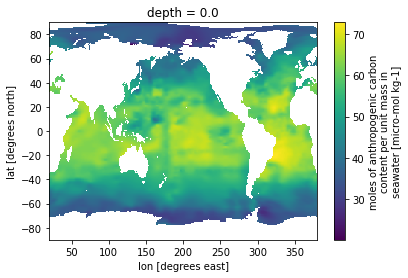

In [19]:
ds = glodap.open_glodap('GLODAPv2.2016b_MappedClimatologies')
ds.Cant.isel(depth=0).plot()

In [20]:
mmol_to_PgC = 12. * 1e-3 * 1e-15
products = ['GLODAPv2.2016b_MappedClimatologies', 'GLODAPv1', 'GLODAPv1+Gruber2019']
product_short_names = {
    'GLODAPv2.2016b_MappedClimatologies': 'GLODAPv2',
    'GLODAPv1': 'GLODAPv1',
    'GLODAPv1+Gruber2019': 'Gruber et al. (2019)',
}
µmolkg_to_mmolm3 = 1026. * 1e-3

lines = []
for product in products:
    
    if product == 'GLODAPv1':
        v = 'Cant_v1'  
    elif product == 'GLODAPv1+Gruber2019':
        v = 'Cant_v1pGruber2019'        
    else:
        v = 'Cant'
    
    entry = dict(product=product_short_names[product])
    
    # compute on native grid
    ds = glodap.open_glodap(product)
    masked_vol = ds.dz.drop('depth') * ds.area * ds[v].notnull().drop('depth')
    
    var = ds[v].where(ds[v] > 0.).fillna(0.).drop('depth')
    inv = (var * µmolkg_to_mmolm3 * masked_vol).sum().values * mmol_to_PgC
    entry['Obs (native)'] = inv
    
    # compute on POP grid
    ds = glodap.open_glodap_pop_grid(product)    
    masked_vol = vol * ds[v].notnull().drop(['z_t'])
    pop_mask = masked_vol
    
    var = ds[v].where(ds[v] > 0.).fillna(0.).drop(['z_t'])
    inv = (var * µmolkg_to_mmolm3 * masked_vol).sum().values * mmol_to_PgC
    entry['Obs (POP)'] = inv   
    
    # compute model inventories
    var = ds_cesm[v][v].where(ds_cesm[v][v] > 0.).fillna(0.).drop(['z_t'])
    inv = (var * pop_mask).sum().values * mmol_to_PgC
    entry['CESM (obs-mask)'] = inv
    
    inv = (var * vol).sum().values * mmol_to_PgC
    entry['CESM'] = inv
    lines.append(entry)
        
df = pd.DataFrame(lines).set_index('product')
df

exists: /glade/work/mclong/adhoc-regridding/POP_gx1v7.nc
exists: /glade/work/mclong/adhoc-regridding/latlon_glodapv2.nc
source grid dims: (180, 360)
destination grid dims: (384, 320)
exists: /glade/work/mclong/adhoc-regridding/POP_gx1v7.nc
exists: /glade/work/mclong/adhoc-regridding/latlon_glodapv1.nc
source grid dims: (180, 360)
destination grid dims: (384, 320)
exists: /glade/work/mclong/adhoc-regridding/POP_gx1v7.nc
exists: /glade/work/mclong/adhoc-regridding/latlon_glodapv1.nc
source grid dims: (180, 360)
destination grid dims: (384, 320)


,Obs (native),Obs (POP),CESM (obs-mask),CESM
product,,,,
GLODAPv2,166.290771,166.756835,101.532239,103.764172
GLODAPv1,107.141279,107.787029,84.708898,90.440270
Gruber et al. (2019),135.269590,137.383126,106.488575,114.485979


In [21]:
[v for v in ds_za.data_vars  if 'Gruber' in v]

['Cant_v1pGruber2019_obs']

In [22]:
ds_tmp = xr.merge([ds for ds in ds_cesm.values()])
ds_tmp = utils.zonal_mean_via_fortran(ds_tmp, 
                                      ','.join(ds_cesm.keys()), grid='POP_gx1v7', 
                                      region_mask=mask2d)
ds_tmp['z_t'] = ds_za.z_t
ds_za = xr.merge((ds_tmp, ds_za))

for v in ['pCFC11', 'pCFC12', 'Cant', 'Cant_v1', 'Cant_v1pGruber2019', 'Del14C']:
    ds_za[f'{v}_bias'] = ds_za[v] - ds_za[f'{v}_obs']
ds_za

za ran successfully, writing netcdf output


<xarray.Dataset>
Dimensions:                  (basins: 4, lat_t: 394, lat_t_edges: 395, z_t: 60)
Coordinates:
  * basins                   (basins) object 'Global' ... 'Indian Ocean'
  * lat_t                    (lat_t) float32 -79.22 -78.69 -78.15 ... 89.37 89.9
  * lat_t_edges              (lat_t_edges) float32 -79.49 -78.95 ... 89.64 90.0
  * z_t                      (z_t) float64 500.0 1.5e+03 ... 5.125e+05 5.375e+05
Data variables: (12/20)
    Cant                     (basins, z_t, lat_t) float32 ...
    Cant_v1                  (basins, z_t, lat_t) float32 ...
    Cant_v1pGruber2019       (basins, z_t, lat_t) float32 ...
    ALK                      (basins, z_t, lat_t) float32 ...
    pCFC11                   (basins, z_t, lat_t) float32 ...
    pCFC12                   (basins, z_t, lat_t) float32 ...
    ...                       ...
    pCFC11_bias              (basins, z_t, lat_t) float64 nan nan ... nan nan
    pCFC12_bias              (basins, z_t, lat_t) float64 nan nan ... nan nan
    Cant_bias                (basins, z_t, lat_t) float64 nan nan ... nan nan
    Cant_v1_bias             (basins, z_t, lat_t) float64 nan nan ... nan nan
    Cant_v1pGruber2019_bias  (basins, z_t, lat_t) float64 nan nan ... nan nan
    Del14C_bias              (basins, z_t, lat_t) float64 nan nan ... nan nan

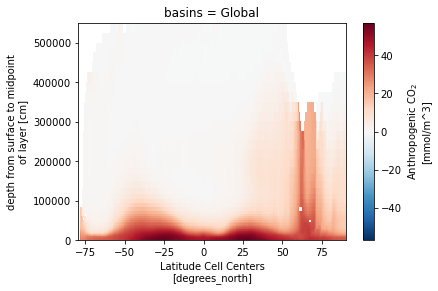

In [23]:
ds_za.Cant.isel(basins=0).plot()

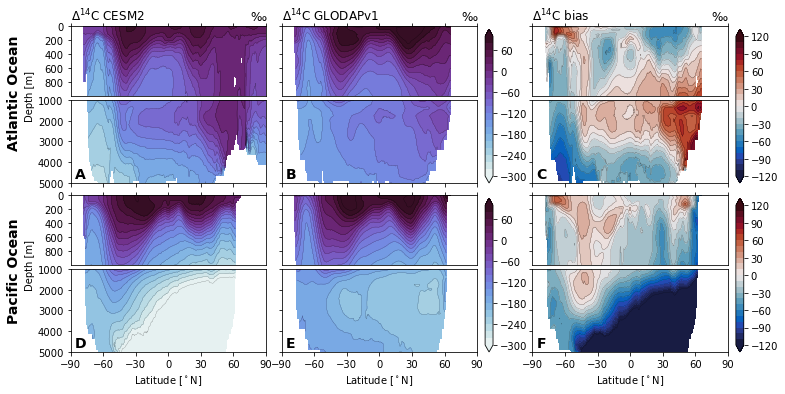

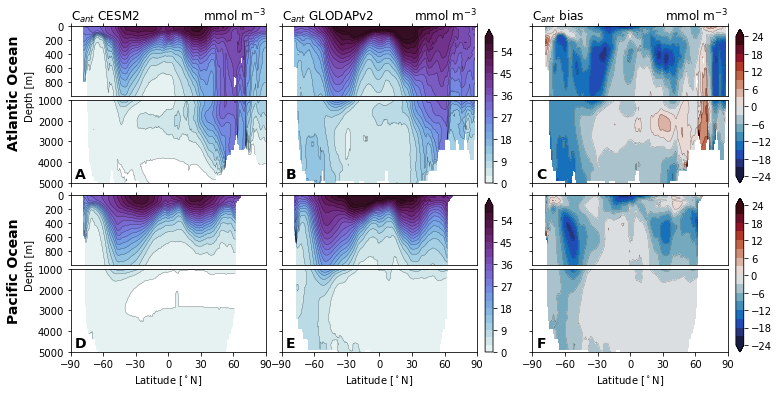

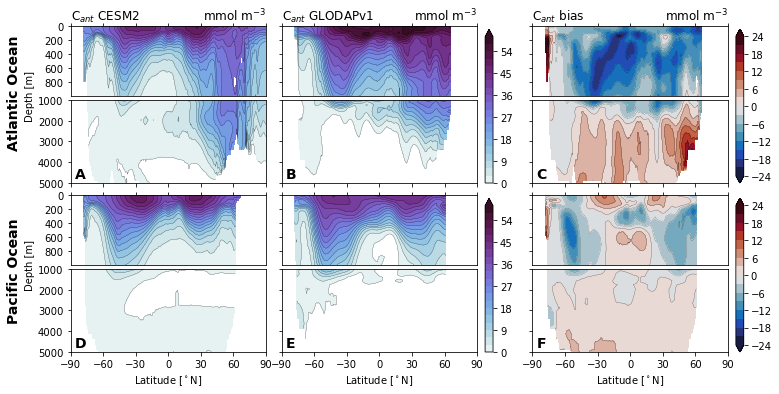

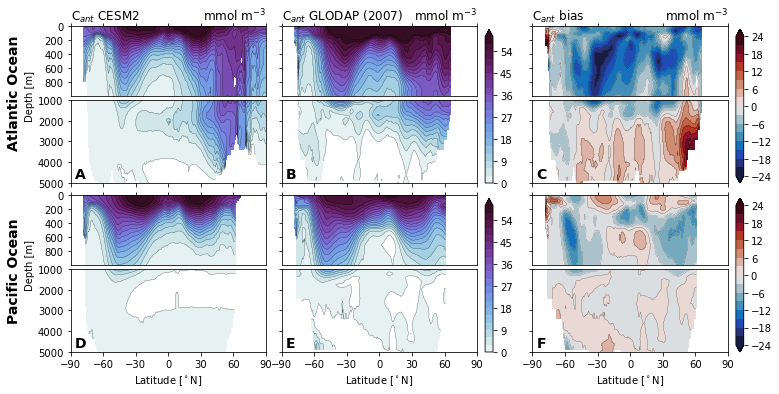

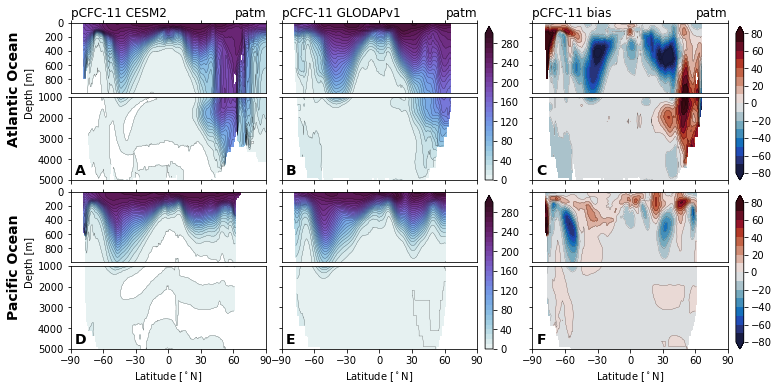

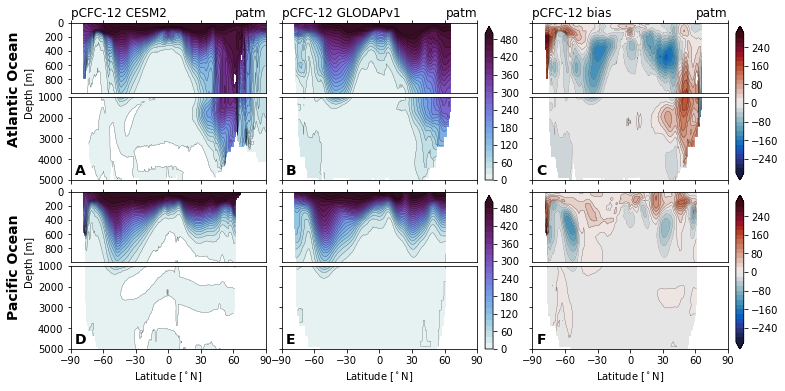

In [25]:
import plot

levels = dict(
    Cant=np.arange(0, 63, 3),
    Cant_v1=np.arange(0, 63, 3),    
    Cant_v1pGruber2019=np.arange(0, 63, 3),        
    pCFC11=np.arange(0, 310, 10),
    pCFC12=np.arange(0, 520, 20),
    Del14C=np.arange(-300, 120, 20),    
    ALK=np.arange(1800, 2600, 200),        
)

    
levels_bias = dict(
    Cant=np.arange(-24, 27, 3),
    Cant_v1=np.arange(-24, 27, 3),
    Cant_v1pGruber2019=np.arange(-24, 27, 3),
    pCFC11=np.arange(-80, 90, 10),    
    pCFC12=np.arange(-300, 320, 20),        
    Del14C=np.arange(-120, 130, 10),        
)  

for field in ['Del14C', 'Cant', 'Cant_v1', 'Cant_v1pGruber2019', 'pCFC11', 'pCFC12',]:
    glodap_str = (
        'GLODAPv2' if field == 'Cant' else 
        'GLODAP (2007)' if field == 'Cant_v1pGruber2019' 
        else 'GLODAPv1'
    )
                  
    plot.za_obs_comparison(
        ds_za, 
        field=field, 
        levels=levels[field], 
        levels_bias=levels_bias[field],
        col_name=['CESM2', glodap_str, 'bias'],
    )
    utils.savefig(f'za-obs-comparison-{field}.pdf')